In [1]:
from sympy import *
from sympy.abc import *
from sympy.galgebra.ga import *
import numpy as np
from numpy import linalg as LA
from __future__ import print_function
init_printing()

## PDE 
The acoustic wave equation for the square slowness m and a source q is given in 3D by :

\begin{cases} 
 &m \frac{d^2 u(x,t)}{dt^2} - \nabla^2 u(x,t) =q  \\
 &u(.,0) = 0 \\
 &\frac{d u(x,t)}{dt}|_{t=0} = 0 
\end{cases}

with the zero initial conditons to guaranty unicity of the solution

In [2]:
p=Function('p')
m,s,h = symbols('m s h')
m=M(x,y,z)
q=Q(x,y,z,t)
d=D(x,y,z,t)
e=E(x,y,z)

In [3]:
# Choose dimension (2 or 3)
dim = 3
# Choose order
time_order = 2
space_order = 2

# half width for indexes, goes from -half to half
width_t = int(time_order/2)
width_h = int(space_order/2)
solvep = p(x,y,z,t+width_t*s)
solvepa = p(x,y,z,t-width_t*s)

In [4]:
# Indexes for finite differences
indx = []
indy = []
indz = []
indt = []
for i in range(-width_h,width_h+1):
    indx.append(x + i * h)
    indy.append(y + i * h)
    indz.append(z + i* h)
    
for i in range(-width_t,width_t+1):
    indt.append(t + i * s)

In [5]:
# Finite differences
dtt=as_finite_diff(p(x,y,z,t).diff(t,t),indt)
dxx=as_finite_diff(p(x,y,z,t).diff(x,x), indx) 
dyy=as_finite_diff(p(x,y,z,t).diff(y,y), indy) 
dzz=as_finite_diff(p(x,y,z,t).diff(z,z), indz)
dt=as_finite_diff(p(x,y,z,t).diff(t), indt)
lap = dxx + dyy + dzz

In [6]:
arglamb=[]
arglamba=[]
for i in range(-width_t,width_t):
    arglamb.append( p(x,y,z,indt[i+width_t]))
    arglamba.append( p(x,y,z,indt[i+width_t+1]))
        
for i in range(-width_h,width_h+1):
    arglamb.append( p(indx[i+width_h],y,z,t))
    arglamba.append( p(indx[i+width_h],y,z,t))
    
for i in range(-width_h,width_h+1):
    arglamb.append( p(x,indy[i+width_h],z,t))
    arglamba.append( p(x,indy[i+width_h],z,t))
    
for i in range(-width_h,width_h+1):
    arglamb.append( p(x,y,indz[i+width_h],t))
    arglamba.append( p(x,y,indz[i+width_h],t))
        
arglamb.extend((q , m, s, h, e))
arglamb=tuple(arglamb)
arglamba.extend((q , m, s, h, e))
arglamba=tuple(arglamba)

arglamb=[ii for n,ii in enumerate(arglamb) if ii not in arglamb[:n]]

In [13]:
arglamb

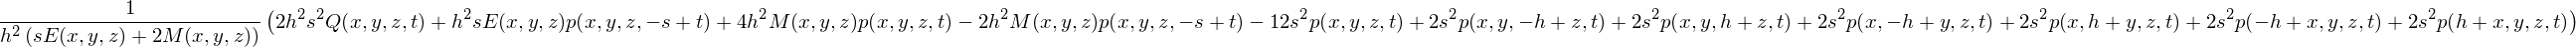

In [7]:
# Forward wave equation
wave_equation = m*dtt- lap - q  + e*dt
stencil = solve(wave_equation,solvep)[0]
ts=lambdify(arglamb,stencil,"numpy")
stencil

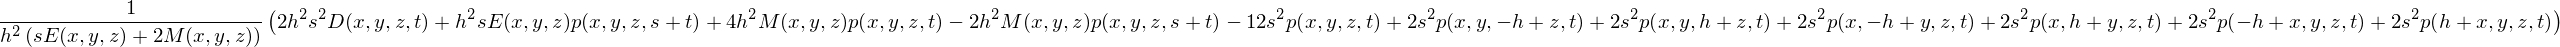

In [8]:
# Adjoint wave equation
wave_equationA = m*dtt- lap - d - e*dt
stencilA = solve(wave_equationA,solvepa)[0]
tsA=lambdify(arglamba,stencilA,"numpy")
stencilA

# Forward modelling
Point source on the grid
No receivers
Non cube grid (to make it general)

In [9]:
import matplotlib.pyplot as plt
from matplotlib import animation

hstep=25 #space increment d  = minv/(10*f0);
tstep=2 #time increment dt < .5 * hstep /maxv;
tmin=0.0 #initial time
tmax=300 #simulate until
xmin=-500.0 #left bound
xmax=500.0 #right bound...assume packet never reaches boundary
ymin=-600.0 #left bound
ymax=600.0 #right bound...assume packet never reaches boundary
zmin=-250.0 #left bound
zmax=400.0 #right bound...assume packet never reaches boundary
f0=.010
t0=1/.010
nbpml=10
nx = int((xmax-xmin)/hstep) + 1 #number of points on x grid
ny = int((ymax-ymin)/hstep) + 1 #number of points on x grid
nz = int((zmax-zmin)/hstep) + 1 #number of points on x grid
nt = int((tmax-tmin)/tstep) + 2 #number of points on t grid
xsrc=0.0
ysrc=0.0
zsrc=25.0
#set source as Ricker wavelet for f0 
def source(x,y,z,t):
    r = (np.pi*f0*(t-t0))
    val = (1-2.*r**2)*np.exp(-r**2)
    if abs(x-xsrc)<hstep/2 and abs(y-ysrc)<hstep/2 and abs(z-zsrc)<hstep/2:
        return val
    else:
        return 0.0
    
def dampx(x):
    dampcoeff=1.5*np.log(1.0/0.001)/(5.0*hstep);
    if x<nbpml:
        return dampcoeff*((nbpml-x)/nbpml)**2
    elif x>nx-nbpml-1:
        return dampcoeff*((x-nx+nbpml)/nbpml)**2
    else:
        return 0.0
def dampy(y):
    dampcoeff=1.5*np.log(1.0/0.001)/(5.0*hstep);
    if y<nbpml:
        return dampcoeff*((nbpml-y)/nbpml)**2
    elif y>ny-nbpml-1:
        return dampcoeff*((y-ny+nbpml)/nbpml)**2
    else:
        return 0.0
    
def dampz(z):
    dampcoeff=1.5*np.log(1.0/0.001)/(5.0*hstep);
    if z<nbpml:
        return dampcoeff*((nbpml-z)/nbpml)**2
    elif z>nz-nbpml-1:
        return dampcoeff*((z-ny+nbpml)/nbpml)**2
    else:
        return 0.0

In [10]:
# True velocity
vel=np.ones((nx,ny,nz)) + 2.0
vel[:,:,int(nz/2):nz]=4.5
mt=vel**-2

In [14]:
def Forward(nt,nx,ny,nz,m):
    u=np.zeros((nt+2,nx,ny,nz))
    for ti in range(2,nt+2):
        for a in range(1,nx-1):
            for b in range(1,ny-1):
                for c in range(1,nz-1):
                    src = source(xmin+a*hstep,ymin+b*hstep,zmin+c*hstep,tstep*ti)
                    damp=dampx(a)+dampy(b)+dampz(c)
                    u[ti,a,b,c]=ts(u[ti-2,a,b,c], 
                                   u[ti-1,a,b,c],
                                   u[ti-1,a-1,b,c], 
                                   u[ti-1,a+1,b,c],
                                   u[ti-1,a,b-1,c],
                                   u[ti-1,a,b+1,c],
                                   u[ti-1,a,b,c-1],
                                   u[ti-1,a,b,c+1],
                                   src , m[a,b,c], tstep, hstep, damp)
    return u


In [15]:
u = Forward(nt,nx,ny,nz,mt)

TypeError: can't convert expression to float